
# import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from scipy.interpolate import interp1d
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.layers import TimeDistributed
print('OK')

OK


# load dataset

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#authenticate and create the python client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
path = 'https://drive.google.com/file/d/1FAidmv6FxjbUEWveqc2oV6cpb-cXQ20R/view?usp=drive_link'
id = path.split('/')[-2]

downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('PRSA_Data_Aotizhongxin_20130301-20170228.csv')

df = pd.read_csv('PRSA_Data_Aotizhongxin_20130301-20170228.csv')
print(df)

          No  year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  \
0          1  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0   
1          2  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0   
2          3  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0   
3          4  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0   
4          5  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0   
...      ...   ...    ...  ...   ...    ...   ...   ...   ...    ...   ...   
35059  35060  2017      2   28    19   12.0  29.0   5.0  35.0  400.0  95.0   
35060  35061  2017      2   28    20   13.0  37.0   7.0  45.0  500.0  81.0   
35061  35062  2017      2   28    21   16.0  37.0  10.0  66.0  700.0  58.0   
35062  35063  2017      2   28    22   21.0  44.0  12.0  87.0  700.0  35.0   
35063  35064  2017      2   28    23   19.0  31.0  10.0  79.0  600.0  42.0   

       TEMP    PRES  DEWP  RAIN   wd  WSPM       station  
0   

In [4]:
del df['No']
del df['year']
del df['month']
del df['hour']
del df['day']
del df['station']

# Add Spatial info

In [5]:
path_dict = {'Changping': 'https://drive.google.com/file/d/1vTiqDClgkzyQoa82EIOiL-HY4YBBQRkv/view?usp=drive_link',
             'Dingling': 'https://drive.google.com/file/d/1cMcM17vIhT1PNS1C3RIiK7M9y1DdHH8Q/view?usp=drive_link',
             'Dongsi': 'https://drive.google.com/file/d/1EgaRYUpxJhyjv0a6ZFIXcjNer5UDt83u/view?usp=drive_link',
             'Guanyuan': 'https://drive.google.com/file/d/1yUa7phkKX_1I6mC5JgU7XOFBsnE1B76w/view?usp=drive_link',
             'Gucheng': 'https://drive.google.com/file/d/1hmYamHg5qhp9U0iM0HJABTkD_aEdP0Ot/view?usp=drive_link',
             'Huairou': 'https://drive.google.com/file/d/1Jel1D0PjOyEUZztak_Qe5Xntv-L_x4BS/view?usp=drive_link',
             'Nangzhanguan': 'https://drive.google.com/file/d/1GzY51aUHyK1_kXKhMqemCC9htKxRpHEm/view?usp=drive_link',
             'Shunyi': 'https://drive.google.com/file/d/1e2w48wtwX5m-NmSWbl4brHUbfdg1oQb1/view?usp=drive_link',
             'Tiantan': 'https://drive.google.com/file/d/1t0vBX1vfFOLeWJCg6I6AXQjqVZpCmXbY/view?usp=drive_link',
             'Wanliu': 'https://drive.google.com/file/d/1iBGd36oM4ZHy7JzNd5e3HGYH1ylAbIj7/view?usp=drive_link',
             'Wanshoksigoung': 'https://drive.google.com/file/d/1dE9dhOZelj1VRZh9z1pl9RYhGppLko79/view?usp=drive_link'}

for city, path in path_dict.items():
  id = path.split('/')[-2]
  downloaded = drive.CreateFile({'id': id})
  downloaded.GetContentFile('file.csv')

  df2 = pd.read_csv('file.csv')
  PM2 = df2['PM2.5']
  PM2.rename('PM2.5'+city, inplace=True)
  df = pd.concat([df, PM2], axis=1)

print(df)




       PM2.5  PM10   SO2   NO2     CO    O3  TEMP    PRES  DEWP  RAIN  ...  \
0        4.0   4.0   4.0   7.0  300.0  77.0  -0.7  1023.0 -18.8   0.0  ...   
1        8.0   8.0   4.0   7.0  300.0  77.0  -1.1  1023.2 -18.2   0.0  ...   
2        7.0   7.0   5.0  10.0  300.0  73.0  -1.1  1023.5 -18.2   0.0  ...   
3        6.0   6.0  11.0  11.0  300.0  72.0  -1.4  1024.5 -19.4   0.0  ...   
4        3.0   3.0  12.0  12.0  300.0  72.0  -2.0  1025.2 -19.5   0.0  ...   
...      ...   ...   ...   ...    ...   ...   ...     ...   ...   ...  ...   
35059   12.0  29.0   5.0  35.0  400.0  95.0  12.5  1013.5 -16.2   0.0  ...   
35060   13.0  37.0   7.0  45.0  500.0  81.0  11.6  1013.6 -15.1   0.0  ...   
35061   16.0  37.0  10.0  66.0  700.0  58.0  10.8  1014.2 -13.3   0.0  ...   
35062   21.0  44.0  12.0  87.0  700.0  35.0  10.5  1014.4 -12.9   0.0  ...   
35063   19.0  31.0  10.0  79.0  600.0  42.0   8.6  1014.1 -15.9   0.0  ...   

      PM2.5Dingling  PM2.5Dongsi  PM2.5Guanyuan  PM2.5Gucheng  

# Encoding Categorical variables

In [6]:
df.columns

Index(['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'wd', 'WSPM', 'PM2.5Changping', 'PM2.5Dingling', 'PM2.5Dongsi',
       'PM2.5Guanyuan', 'PM2.5Gucheng', 'PM2.5Huairou', 'PM2.5Nangzhanguan',
       'PM2.5Shunyi', 'PM2.5Tiantan', 'PM2.5Wanliu', 'PM2.5Wanshoksigoung'],
      dtype='object')

In [7]:
#method two as in article used
wind_directions = {
    "N": 0.0,
    "NNE": 22.5,
    "NE": 45.0,
    "ENE": 67.5,
    "E": 90.0,
    "ESE": 112.5,
    "SE": 135.0,
    "SSE": 157.5,
    "S": 180.0,
    "SSW": 202.5,
    "SW": 225.0,
    "WSW": 247.5,
    "W": 270.0,
    "WNW": 292.5,
    "NW": 315.0,
    "NNW": 337.5
}

df['wd'] = df['wd'].replace(wind_directions)

In [8]:
print(df['wd'])
null = pd.isnull(df['wd'])
df[null]

0        337.5
1          0.0
2        337.5
3        315.0
4          0.0
         ...  
35059    315.0
35060    292.5
35061    315.0
35062    337.5
35063     22.5
Name: wd, Length: 35064, dtype: float64


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,PM2.5Dingling,PM2.5Dongsi,PM2.5Guanyuan,PM2.5Gucheng,PM2.5Huairou,PM2.5Nangzhanguan,PM2.5Shunyi,PM2.5Tiantan,PM2.5Wanliu,PM2.5Wanshoksigoung
6388,82.0,74.0,15.0,75.0,1300.0,NaN,-3.200,1020.5,-4.0,0.0,...,34.0,106.0,125.0,97.0,47.0,128.0,32.0,156.0,148.0,143.0
11718,44.0,44.0,2.0,16.0,800.0,105.0,21.500,998.2,21.5,0.1,...,39.0,49.0,45.0,43.0,34.0,49.0,32.0,45.0,48.0,41.0
13412,56.0,141.0,13.0,81.0,700.0,99.0,21.700,1008.0,15.8,0.0,...,33.0,68.0,52.0,61.0,76.0,52.0,61.0,43.0,48.0,57.0
16748,26.0,42.0,12.0,78.0,1300.0,2.0,NaN,NaN,NaN,NaN,...,39.0,35.0,30.0,49.0,57.0,36.0,33.0,26.0,22.0,40.0
17263,13.0,14.0,12.0,22.0,600.0,60.0,NaN,NaN,NaN,NaN,...,6.0,12.0,10.0,15.0,8.0,12.0,6.0,14.0,19.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34314,246.0,266.0,63.0,82.0,300.0,51.0,0.625,1016.0,-7.9,0.0,...,218.0,258.0,244.0,234.0,196.0,220.0,210.0,230.0,233.0,257.0
34334,15.0,55.0,4.0,6.0,300.0,80.0,-1.220,1025.0,-21.6,0.0,...,14.0,15.0,13.0,12.0,11.0,12.0,11.0,11.0,12.0,13.0
34560,113.0,124.0,17.0,105.0,2600.0,2.0,-2.800,1026.3,-7.0,0.0,...,86.0,121.0,108.0,109.0,86.0,106.0,120.0,99.0,115.0,104.0
34638,15.0,24.0,16.0,71.0,600.0,25.0,-4.600,1025.0,-18.1,0.0,...,7.0,19.0,16.0,15.0,15.0,9.0,10.0,12.0,21.0,10.0


# fill missing values using Linear spline imputation



       PM2.5   PM10   SO2  NO2      CO    O3  TEMP    PRES  DEWP  RAIN  ...  \
76       7.0   18.0  14.0  NaN   400.0  42.0   6.0  1018.0 -11.6   0.0  ...   
172    322.0  345.0  62.0  NaN  3299.0  84.0   1.3   998.5  -1.8   0.0  ...   
1109    50.0  156.0  46.0  NaN  1300.0  11.0   8.5   998.7   2.3   0.0  ...   
1110    58.0  185.0  35.0  NaN  1300.0   2.0  10.1   999.6   2.4   0.0  ...   
1111    57.0  185.0  35.0  NaN  1300.0   7.0  13.3  1000.5   3.1   0.0  ...   
...      ...    ...   ...  ...     ...   ...   ...     ...   ...   ...  ...   
34883    NaN    NaN   NaN  NaN     NaN   NaN   1.3  1028.0 -16.1   0.0  ...   
34885    NaN    NaN   NaN  NaN     NaN   NaN  -2.1  1027.4  -4.1   0.7  ...   
35027  122.0  122.0   NaN  NaN     NaN  42.0  10.0  1018.3  -5.6   0.0  ...   
35028    NaN    NaN   NaN  NaN     NaN   NaN  12.1  1017.3  -5.4   0.0  ...   
35029    NaN    NaN   NaN  NaN     NaN   NaN  14.0  1015.8  -5.2   0.0  ...   

       PM2.5Dingling  PM2.5Dongsi  PM2.5Guanyuan  P

<function matplotlib.pyplot.show(close=None, block=None)>

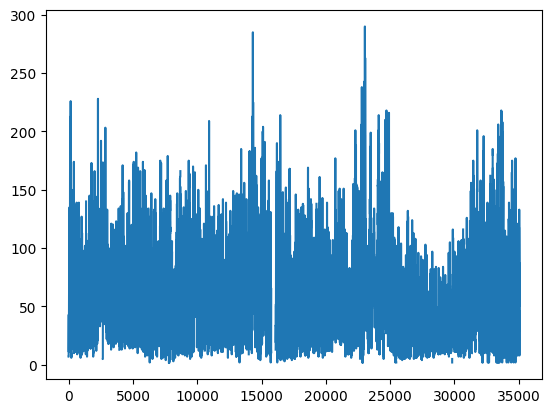

In [9]:
null = pd.isnull(df['NO2'])
print(df[null])
plt.plot(df['NO2'])
plt.show

Empty DataFrame
Columns: [PM2.5, PM10, SO2, NO2, CO, O3, TEMP, PRES, DEWP, RAIN, wd, WSPM, PM2.5Changping, PM2.5Dingling, PM2.5Dongsi, PM2.5Guanyuan, PM2.5Gucheng, PM2.5Huairou, PM2.5Nangzhanguan, PM2.5Shunyi, PM2.5Tiantan, PM2.5Wanliu, PM2.5Wanshoksigoung]
Index: []

[0 rows x 23 columns]


<function matplotlib.pyplot.show(close=None, block=None)>

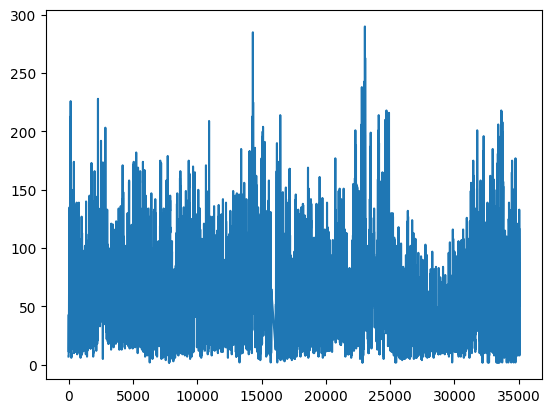

In [10]:
'''for column in df.columns:
  df[column] = df[column].interpolate(option = 'spline')'''

df.interpolate(method='linear', inplace=True)

null = pd.isnull(df['NO2'])
print(df[null])
plt.plot(df['NO2'])
plt.show

# Feature selection

In [11]:
print(df.columns)
air_quality_features = ['O3', 'CO', 'NO2', 'SO2', 'PM10', 'PM2.5']
correlation_matrix = df[air_quality_features].corr()

correlation_matrix

Index(['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'wd', 'WSPM', 'PM2.5Changping', 'PM2.5Dingling', 'PM2.5Dongsi',
       'PM2.5Guanyuan', 'PM2.5Gucheng', 'PM2.5Huairou', 'PM2.5Nangzhanguan',
       'PM2.5Shunyi', 'PM2.5Tiantan', 'PM2.5Wanliu', 'PM2.5Wanshoksigoung'],
      dtype='object')


,O3,CO,NO2,SO2,PM10,PM2.5
O3,1.000000,-0.320600,-0.495797,-0.206802,-0.141969,-0.160271
CO,-0.320600,1.000000,0.687243,0.523269,0.682026,0.786052
NO2,-0.495797,0.687243,1.000000,0.430005,0.650040,0.682795
SO2,-0.206802,0.523269,0.430005,1.000000,0.469399,0.479025
PM10,-0.141969,0.682026,0.650040,0.469399,1.000000,0.875198
PM2.5,-0.160271,0.786052,0.682795,0.479025,0.875198,1.000000


<function matplotlib.pyplot.show(close=None, block=None)>

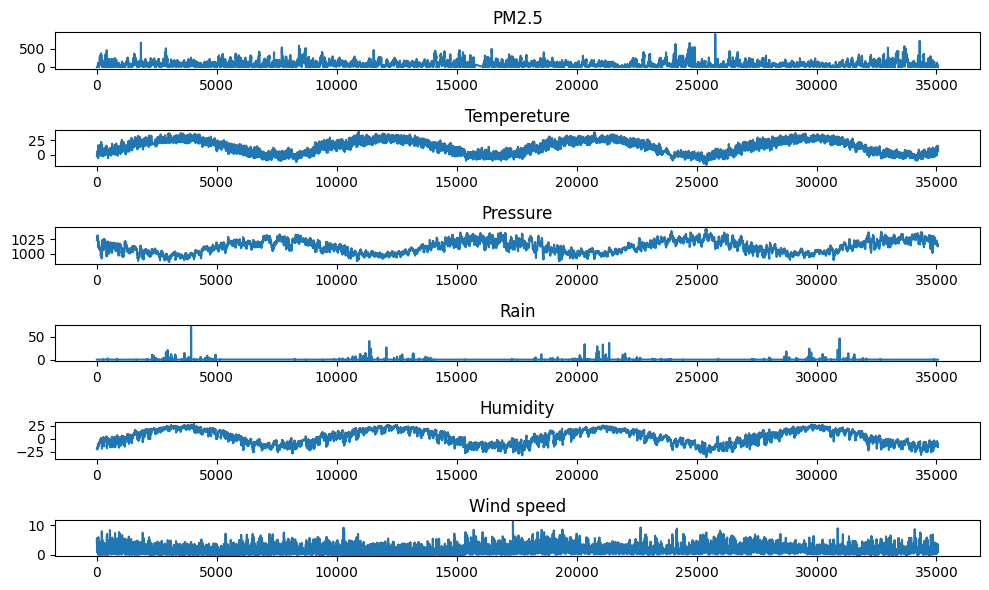

In [12]:
del df['SO2']
del df['NO2']
del df['O3']

fig, axs = plt.subplots(6, 1, figsize=(10, 6))
axs[0].plot(df['PM2.5'])
axs[0].set_title('PM2.5')
axs[1].plot(df['TEMP'])
axs[1].set_title('Tempereture')
axs[2].plot(df['PRES'])
axs[2].set_title('Pressure')
axs[3].plot(df['RAIN'])
axs[3].set_title('Rain')
axs[4].plot(df['DEWP'])
axs[4].set_title('Humidity')
axs[5].plot(df['WSPM'])
axs[5].set_title('Wind speed')
plt.tight_layout()
plt.show

In [13]:
spatial_features = ['PM2.5', 'PM2.5Changping', 'PM2.5Dingling', 'PM2.5Dongsi', 'PM2.5Guanyuan',
       'PM2.5Gucheng', 'PM2.5Huairou', 'PM2.5Nangzhanguan', 'PM2.5Shunyi',
       'PM2.5Tiantan', 'PM2.5Wanliu', 'PM2.5Wanshoksigoung']

correlation_matrix = df[spatial_features].corr()
correlation_matrix

,PM2.5,PM2.5Changping,PM2.5Dingling,PM2.5Dongsi,PM2.5Guanyuan,PM2.5Gucheng,PM2.5Huairou,PM2.5Nangzhanguan,PM2.5Shunyi,PM2.5Tiantan,PM2.5Wanliu,PM2.5Wanshoksigoung
PM2.5,1.000000,0.841353,0.821206,0.949480,0.953684,0.900578,0.846866,0.942509,0.891472,0.930921,0.938450,0.919670
PM2.5Changping,0.841353,1.000000,0.905927,0.817355,0.839291,0.852206,0.850342,0.810483,0.806379,0.809272,0.866185,0.794462
PM2.5Dingling,0.821206,0.905927,1.000000,0.795866,0.819929,0.833678,0.854425,0.788059,0.800437,0.782807,0.838785,0.768186
PM2.5Dongsi,0.949480,0.817355,0.795866,1.000000,0.963756,0.898599,0.830904,0.959063,0.884516,0.960272,0.929671,0.947031
PM2.5Guanyuan,0.953684,0.839291,0.819929,0.963756,1.000000,0.923182,0.847504,0.945525,0.881540,0.954423,0.954065,0.947147
PM2.5Gucheng,0.900578,0.852206,0.833678,0.898599,0.923182,1.000000,0.855795,0.880511,0.857053,0.892194,0.933817,0.892820
PM2.5Huairou,0.846866,0.850342,0.854425,0.830904,0.847504,0.855795,1.000000,0.819496,0.892737,0.820332,0.852650,0.808093
PM2.5Nangzhanguan,0.942509,0.810483,0.788059,0.959063,0.945525,0.880511,0.819496,1.000000,0.883288,0.954239,0.916396,0.936738
PM2.5Shunyi,0.891472,0.806379,0.800437,0.884516,0.881540,0.857053,0.892737,0.883288,1.000000,0.877899,0.870998,0.868550
PM2.5Tiantan,0.930921,0.809272,0.782807,0.960272,0.954423,0.892194,0.820332,0.954239,0.877899,1.000000,0.923609,0.963663


# Normalization

In [14]:
df

,PM2.5,PM10,CO,TEMP,PRES,DEWP,RAIN,wd,WSPM,PM2.5Changping,PM2.5Dingling,PM2.5Dongsi,PM2.5Guanyuan,PM2.5Gucheng,PM2.5Huairou,PM2.5Nangzhanguan,PM2.5Shunyi,PM2.5Tiantan,PM2.5Wanliu,PM2.5Wanshoksigoung
0,4.0,4.0,300.0,-0.7,1023.0,-18.8,0.0,337.5,4.4,3.0,4.0,9.0,4.0,6.0,7.0,5.0,3.0,6.0,8.0,9.0
1,8.0,8.0,300.0,-1.1,1023.2,-18.2,0.0,0.0,4.7,3.0,7.0,4.0,4.0,6.0,4.0,8.0,12.0,6.0,9.0,11.0
2,7.0,7.0,300.0,-1.1,1023.5,-18.2,0.0,337.5,5.6,3.0,5.0,7.0,3.0,5.0,4.0,3.0,14.0,6.0,3.0,8.0
3,6.0,6.0,300.0,-1.4,1024.5,-19.4,0.0,315.0,3.1,3.0,6.0,3.0,3.0,6.0,3.0,5.0,12.0,6.0,11.0,8.0
4,3.0,3.0,300.0,-2.0,1025.2,-19.5,0.0,0.0,2.0,3.0,5.0,3.0,3.0,5.0,3.0,5.0,12.0,5.0,3.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,12.0,29.0,400.0,12.5,1013.5,-16.2,0.0,315.0,2.4,28.0,11.0,16.0,13.0,14.0,16.0,14.0,27.0,20.0,11.0,11.0
35060,13.0,37.0,500.0,11.6,1013.6,-15.1,0.0,292.5,0.9,12.0,13.0,18.0,20.0,27.0,21.0,18.0,47.0,11.0,15.0,13.0
35061,16.0,37.0,700.0,10.8,1014.2,-13.3,0.0,315.0,1.1,7.0,9.0,23.0,16.0,22.0,17.0,15.0,18.0,18.0,13.0,14.0
35062,21.0,44.0,700.0,10.5,1014.4,-12.9,0.0,337.5,1.2,11.0,10.0,23.0,11.0,9.0,11.0,11.0,18.0,15.0,12.0,12.0


In [15]:
column_data = df['PM2.5']
scaler = MinMaxScaler()

normalized_data = scaler.fit_transform(column_data.values.reshape(-1, 1))

df['PM2.5'] = normalized_data

normalized_dataset = df.values.astype('float32')

In [16]:
df

,PM2.5,PM10,CO,TEMP,PRES,DEWP,RAIN,wd,WSPM,PM2.5Changping,PM2.5Dingling,PM2.5Dongsi,PM2.5Guanyuan,PM2.5Gucheng,PM2.5Huairou,PM2.5Nangzhanguan,PM2.5Shunyi,PM2.5Tiantan,PM2.5Wanliu,PM2.5Wanshoksigoung
0,0.001117,4.0,300.0,-0.7,1023.0,-18.8,0.0,337.5,4.4,3.0,4.0,9.0,4.0,6.0,7.0,5.0,3.0,6.0,8.0,9.0
1,0.005587,8.0,300.0,-1.1,1023.2,-18.2,0.0,0.0,4.7,3.0,7.0,4.0,4.0,6.0,4.0,8.0,12.0,6.0,9.0,11.0
2,0.004469,7.0,300.0,-1.1,1023.5,-18.2,0.0,337.5,5.6,3.0,5.0,7.0,3.0,5.0,4.0,3.0,14.0,6.0,3.0,8.0
3,0.003352,6.0,300.0,-1.4,1024.5,-19.4,0.0,315.0,3.1,3.0,6.0,3.0,3.0,6.0,3.0,5.0,12.0,6.0,11.0,8.0
4,0.000000,3.0,300.0,-2.0,1025.2,-19.5,0.0,0.0,2.0,3.0,5.0,3.0,3.0,5.0,3.0,5.0,12.0,5.0,3.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,0.010056,29.0,400.0,12.5,1013.5,-16.2,0.0,315.0,2.4,28.0,11.0,16.0,13.0,14.0,16.0,14.0,27.0,20.0,11.0,11.0
35060,0.011173,37.0,500.0,11.6,1013.6,-15.1,0.0,292.5,0.9,12.0,13.0,18.0,20.0,27.0,21.0,18.0,47.0,11.0,15.0,13.0
35061,0.014525,37.0,700.0,10.8,1014.2,-13.3,0.0,315.0,1.1,7.0,9.0,23.0,16.0,22.0,17.0,15.0,18.0,18.0,13.0,14.0
35062,0.020112,44.0,700.0,10.5,1014.4,-12.9,0.0,337.5,1.2,11.0,10.0,23.0,11.0,9.0,11.0,11.0,18.0,15.0,12.0,12.0


# Data and Label sets and Train test split

In [17]:
def to_supervised(dataset, sequence_length):
  X = []
  Y = []
  for i in range(sequence_length, len(dataset)):
    X.append(dataset[i-sequence_length:i, :])
    Y.append(dataset[i, 0:1])

  return np.array(X),np.array(Y)


In [18]:
X, Y = to_supervised(normalized_dataset, 1)
print(X.shape)
print(Y.shape)

(35063, 1, 20)
(35063, 1)


In [19]:
#chronological split (via validation set)
n_train = int(0.7 * len(normalized_dataset))
n_val = int(0.1*len(normalized_dataset))
X_train, X_val, X_test = X[:n_train,], X[n_train: n_train + n_val,], X[n_train + n_val:,]
Y_train, Y_val, Y_test = Y[:n_train,], Y[n_train: n_train + n_val,], Y[n_train + n_val:,]
print(X_test.shape)
print(X_val.shape)
print(X_train.shape)
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

(7013, 1, 20)
(3506, 1, 20)
(24544, 1, 20)
(24544, 1)
(3506, 1)
(7013, 1)


In [20]:
#chronological split(without validation set as used in article)
n_train = int(0.8 * len(normalized_dataset))
X_train, X_test = X[:n_train,], X[n_train:,]
Y_train, Y_test = Y[:n_train,], Y[n_train:,]
print(Y_train.shape)
print(X_train.shape)
print(Y_test.shape)
print(X_test.shape)

(28051, 1)
(28051, 1, 20)
(7012, 1)
(7012, 1, 20)


# LSTM model

In [21]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [22]:
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')

In [23]:
LSTM_model = keras.models.Sequential()
LSTM_model.add(keras.layers.LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
LSTM_model.add(keras.layers.Dropout(0.1))

LSTM_model.add(keras.layers.LSTM(units=100, return_sequences=True, activation='relu'))
LSTM_model.add(keras.layers.Dropout(0.1))

LSTM_model.add(keras.layers.LSTM(units=50, activation='relu', return_sequences=True))
LSTM_model.add(keras.layers.Dropout(0.1))

LSTM_model.add(keras.layers.LSTM(units=50, activation='relu'))
LSTM_model.add(keras.layers.Dropout(0.1))

LSTM_model.add(keras.layers.Dense(units=1, activation='relu'))

LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 200)            176800    
                                                                 
 dropout (Dropout)           (None, 1, 200)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            120400    
                                                                 
 dropout_1 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 50)             30200     
                                                                 
 dropout_2 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [24]:
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-3, patience=50)
optimizer = keras.optimizers.legacy.Adam(learning_rate=0.001, decay=0.0001)
LSTM_model.compile(optimizer=optimizer, loss='mean_squared_error')
history = LSTM_model.fit(X_train, Y_train, epochs=200, batch_size=32, callbacks = [early_stopping])

Epoch 1/200
877/877 [==============================] - 23s 18ms/step - loss: 0.0148
Epoch 2/200
877/877 [==============================] - 15s 17ms/step - loss: 0.0024
Epoch 3/200
877/877 [==============================] - 17s 19ms/step - loss: 0.0015
Epoch 4/200
877/877 [==============================] - 17s 19ms/step - loss: 0.0012
Epoch 5/200
877/877 [==============================] - 15s 17ms/step - loss: 0.0011
Epoch 6/200
877/877 [==============================] - 18s 20ms/step - loss: 0.0011
Epoch 7/200
877/877 [==============================] - 31s 36ms/step - loss: 9.9916e-04
Epoch 8/200
877/877 [==============================] - 22s 25ms/step - loss: 9.6542e-04
Epoch 9/200
877/877 [==============================] - 16s 19ms/step - loss: 9.3750e-04
Epoch 10/200
877/877 [==============================] - 15s 17ms/step - loss: 9.2074e-04
Epoch 11/200
877/877 [==============================] - 15s 17ms/step - loss: 8.4797e-04
Epoch 12/200
877/877 [==============================] 

In [25]:
LSTM_model.evaluate(X_test, Y_test)

220/220 [==============================] - 1s 3ms/step - loss: 6.8663e-04


0.0006866302574053407

In [26]:
Y_pred = LSTM_model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
rmse

220/220 [==============================] - 1s 3ms/step


0.026203632

# CNN-LSTM model

In [27]:
model = keras.models.Sequential()
model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), padding='causal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='causal'))

model.add(keras.layers.MaxPool1D(pool_size=3, padding = 'same'))

model.add(keras.layers.LSTM(units=100, return_sequences=True, dropout = 0.2))

model.add(keras.layers.LSTM(units=50, dropout = 0.3))

model.add(keras.layers.Dense(units = 1, activation='relu'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             3904      
                                                                 
 batch_normalization (BatchN  (None, 1, 64)            256       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             12352     
                                                                 
 batch_normalization_1 (Batc  (None, 1, 64)            256       
 hNormalization)                                                 
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 32)             6176      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 32)           

In [28]:
optimizer = keras.optimizers.legacy.Adam(learning_rate=0.001, decay=0.0001)
model.compile(optimizer=optimizer, loss='mse')
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta = 1e-3, patience= 50)
model_history = model.fit(X_train, Y_train, epochs=200, batch_size=32, callbacks=[early_stopping])

Epoch 1/200
877/877 [==============================] - 17s 8ms/step - loss: 0.0017
Epoch 2/200
877/877 [==============================] - 7s 8ms/step - loss: 0.0011
Epoch 3/200
877/877 [==============================] - 7s 8ms/step - loss: 9.8146e-04
Epoch 4/200
877/877 [==============================] - 7s 8ms/step - loss: 9.4849e-04
Epoch 5/200
877/877 [==============================] - 7s 8ms/step - loss: 8.5746e-04
Epoch 6/200
877/877 [==============================] - 6s 7ms/step - loss: 8.3890e-04
Epoch 7/200
877/877 [==============================] - 7s 8ms/step - loss: 7.7751e-04
Epoch 8/200
877/877 [==============================] - 7s 8ms/step - loss: 7.8056e-04
Epoch 9/200
877/877 [==============================] - 7s 8ms/step - loss: 7.5576e-04
Epoch 10/200
877/877 [==============================] - 7s 8ms/step - loss: 7.2537e-04
Epoch 11/200
877/877 [==============================] - 7s 8ms/step - loss: 7.3735e-04
Epoch 12/200
877/877 [==============================] - 7s 

In [29]:
model.evaluate(X_test, Y_test)


220/220 [==============================] - 2s 4ms/step - loss: 5.7214e-04


0.0005721442867070436

In [30]:
Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_pred, Y_test)
rmse = np.sqrt(mse)
rmse

220/220 [==============================] - 1s 3ms/step


0.023919534

# Evalute models

In [45]:
Y_pred_LSTM = LSTM_model.predict(X_test)

Y_pred_rescaled = scaler.inverse_transform(Y_pred_LSTM)
Y_test_rescaled = scaler.inverse_transform(Y_test)

mse = mean_squared_error(Y_test_rescaled, Y_pred_rescaled)
rmse = np.sqrt(mse)
print('LSTM model RMSE: ' + str(rmse))

mae = mean_absolute_error(Y_test_rescaled, Y_pred_rescaled)
print('LSTM model MAE: ' + str(mae))

r2 = r2_score(Y_test_rescaled, Y_pred_rescaled)
print('LSTM model R2: ' + str(r2))



220/220 [==============================] - 1s 5ms/step
LSTM model RMSE: 23.45225
LSTM model MAE: 14.809956
LSTM model R2: 0.9213079346535233


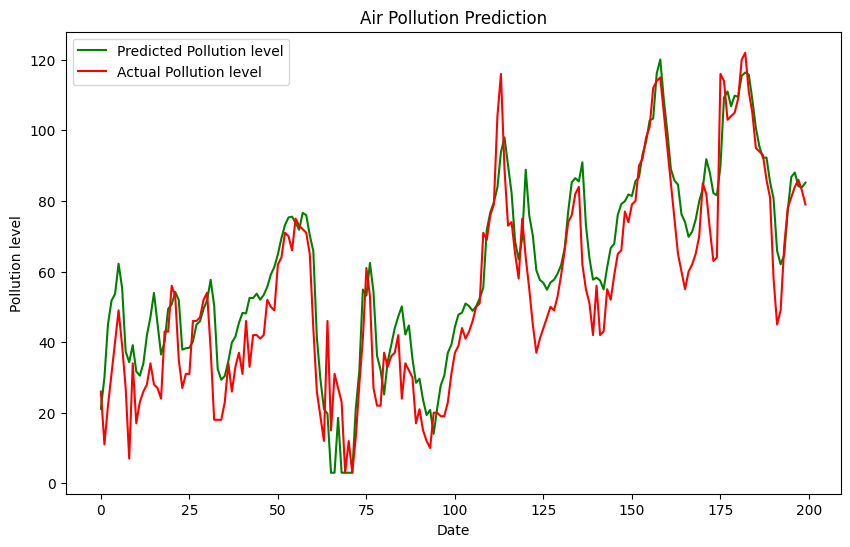

In [46]:
#Plot the graph between actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(Y_pred_rescaled[:200,:], color= 'green',label = 'Predicted Pollution level')
plt.plot(Y_test_rescaled[:200,:] , color = 'red',label = 'Actual Pollution level')
plt.title("Air Pollution Prediction")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.legend()
plt.show()

In [41]:

Y_pred_CNN_LSTM = model.predict(X_test)

Y_pred_rescaled = scaler.inverse_transform(Y_pred_CNN_LSTM)
Y_test_rescaled = scaler.inverse_transform(Y_test)

mse = mean_squared_error(Y_test_rescaled, Y_pred_rescaled)
rmse = np.sqrt(mse)
print('CNN-LSTM model RMSE: ' + str(rmse))

mae = mean_absolute_error(Y_test_rescaled, Y_pred_rescaled)
print('CNN-LSTM model MAE: ' + str(mae))

r2 = r2_score(Y_test_rescaled, Y_pred_rescaled)
print('CNN_LSTM model R2: ' + str(r2))

220/220 [==============================] - 1s 3ms/step
CNN-LSTM model RMSE: 21.407984
CNN-LSTM model MAE: 11.181609
CNN_LSTM model R2: 0.9344287516488198


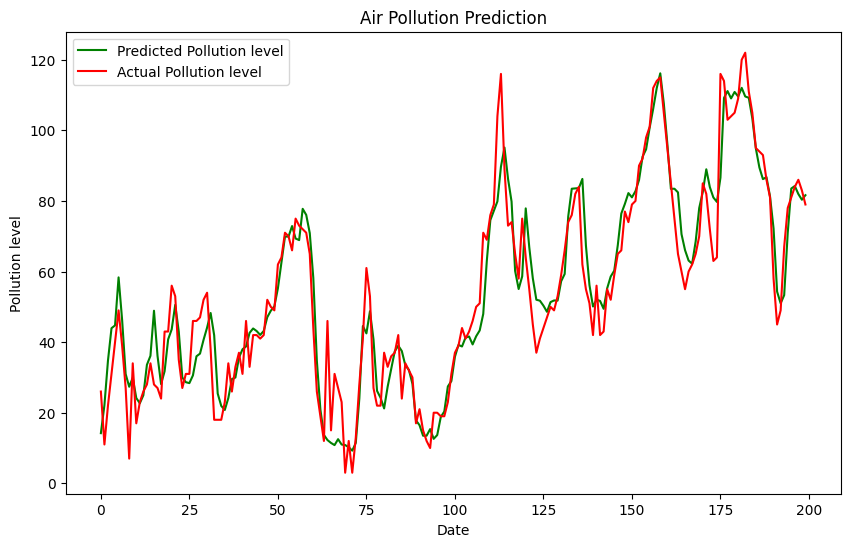

In [44]:
#Plot the graph between actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(Y_pred_rescaled[:200:, :], color= 'green',label = 'Predicted Pollution level')
plt.plot(Y_test_rescaled[:200:, :] , color = 'red',label = 'Actual Pollution level')
plt.title("Air Pollution Prediction")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.legend()
plt.show()